# Cycle GAN

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from IPython.display import display
from tqdm import tqdm
import torchsummary
import random
import glob
from PIL import Image

batch_size = 1
torch.manual_seed(41)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Dataset

In [2]:
class CycleGANDataset(Dataset):
    def __init__(self, dataname, train=True, transforms=None, size=256):
        self.transforms = transforms
        self.size = size
        self.basic_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize(self.size),
            torchvision.transforms.ToTensor(),
        ])
        root_path = f"./datasets/{dataname}/{'train' if train else 'test'}"
        self.data_A = self._make_data(root_path + "A")
        self.data_B = self._make_data(root_path + "B")
        self.data_A_length = len(self.data_A)
        self.data_B_length = len(self.data_B)

    def __getitem__(self, idx):
        data_A = self.data_A[idx]
        data_B = self.data_B[random.randint(0, self.data_B_length - 1)]
        if self.transforms:
            data_A = self.transforms(data_A)
            data_B = self.transforms(data_B)
        return data_A, data_B

    def __len__(self):
        return self.data_A_length

    def _make_data(self, root_dir):
        images = [Image.open(path) for path in glob.glob(root_dir + "/*")]
        assert images, f"No images found. Check the directory: {root_dir}/"
        self.images = images
        data = torch.stack([self.basic_transforms(img) for img in images])
        return data

In [3]:
# dataset_name = "horse2zebra"
# dataset_name = "ukiyoe2photo"
dataset_name = "maps"

dataset = CycleGANDataset(dataset_name)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

N_IMAGES_DISPLAY = 10 # number of images to display per line
test_dataset = CycleGANDataset(dataset_name, train=False)
test_loader = DataLoader(test_dataset, batch_size=N_IMAGES_DISPLAY // 2, shuffle=True)

## Generator

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_block(3, 64, 4, 2, 1) # 128 x 128
        self.conv2 = self.conv_block(64, 128, 4, 2, 1) # 64 x 64
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1) # 32 x 32

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        z1 = self.conv1(x)
        z2 = self.conv2(z1)
        y = self.conv3(z2)
        return y, (z1, z2)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_block(256, 128, 4, 2, 1) # 64 x 64
        self.conv2 = self.conv_block(128 + 128, 64, 4, 2, 1) # 128 x 128
        self.conv3 = nn.ConvTranspose2d(64 + 64, 3, 4, 2, 1) # 256 x 256

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, y, z):
        z1, z2 = z
        x = self.conv1(y)
        x = self.conv2(torch.cat([x, z2], dim=1))
        x = self.conv3(torch.cat([x, z1], dim=1))
        return x


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x):
        y, z = self.encoder(x)
        x = self.decoder(y, z)
        # x = self.sigmoid(x)
        x = self.tanh(x)
        return x

In [5]:
# Original inplementation of Resnet in author's code

import functools

class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.

    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator

        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]
        # model += [nn.Sigmoid()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

## Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.conv_block(3, 64, 4, 2, 1), # 128 x 128
            self.conv_block(64, 128, 4, 2, 1), # 64 x 64
            self.conv_block(128, 256, 4, 2, 1), # 32 x 32
            self.conv_block(256, 512, 4, 2, 1), # 16 x 16
            nn.Conv2d(512, 1, 3, 1, 1), # 16 x 16
        )

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        y = self.net(x)
        return y

In [7]:
# Original inplementation of Discriminator in author's code

class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc=3, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

## Training

In [18]:
# utils
IdtLoss = nn.L1Loss()
CycleLoss = nn.L1Loss()
GANLoss = nn.MSELoss()


def model_init(G_original=False, D_original=False, device=device):
    if G_original:
        G = ResnetGenerator().to(device)
        F = ResnetGenerator().to(device)
    else:
        G = UNet().to(device)
        F = UNet().to(device)

    if D_original:
        Dx = NLayerDiscriminator().to(device)
        Dy = NLayerDiscriminator().to(device)
    else:
        Dx = Discriminator().to(device)
        Dy = Discriminator().to(device)

    opt_gen = optim.Adam([*G.parameters(), *F.parameters()], lr=0.0002, betas=(0.5, 0.999))
    opt_disc = optim.Adam([*Dx.parameters(), *Dy.parameters()], lr=0.0002, betas=(0.5, 0.999))

    return G, F, Dx, Dy, opt_gen, opt_disc


def write_image(G, F, n_lines=1, size=128):
    G.eval(), F.eval()
    display_images = []
    with torch.no_grad():
        for _ in range(n_lines):
            images = next(iter(test_loader))
            x = images[0].to(device)
            y = images[1].to(device)
            y_hat = G(x)
            x_hat = F(y)
            x_recon = F(y_hat)
            y_recon = G(x_hat)
            display_images.append(x)
            display_images.append(y)
            display_images.append(y_hat)
            display_images.append(x_hat)
            display_images.append(x_recon)
            display_images.append(y_recon)

            img = torch.cat(display_images, dim=0)
            img = transforms.Resize(size)(img)
            img = torchvision.utils.make_grid(img, N_IMAGES_DISPLAY)
            img = transforms.functional.to_pil_image(img)
            display(img)


class ModeController:
    def __init__(self, G, F, Dx, Dy):
        self.G = G
        self.F = F
        self.Dx = Dx
        self.Dy = Dy

    def change(self, mode):
        if mode == 'gen':
            self.G.train()
            self.F.train()
            self.Dx.eval()
            self.Dy.eval()
            self.G.zero_grad()
            self.F.zero_grad()
            for p in self.G.parameters(): p.requires_grad = True
            for p in self.F.parameters(): p.requires_grad = True
            # for p in self.Dx.parameters(): p.requires_grad = False
            # for p in self.Dy.parameters(): p.requires_grad = False

        elif mode == 'disc':
            self.G.eval()
            self.F.eval()
            self.Dx.train()
            self.Dy.train()
            self.Dx.zero_grad()
            self.Dy.zero_grad()
            for p in self.G.parameters(): p.requires_grad = False
            for p in self.F.parameters(): p.requires_grad = False
            # for p in self.Dx.parameters(): p.requires_grad = True
            # for p in self.Dy.parameters(): p.requires_grad = True

In [9]:
def train(G, F, Dx, Dy, opt_gen, opt_disc, dataloader, option, disable=False, print_loss=True, write=True):
    n_epochs = option['n_epochs']
    lmd_i = option['lambda_idt']
    lmd_c = option['lambda_cycle']
    lmd_a = option['lambda_adv']
    mode_controller = ModeController(G, F, Dx, Dy)

    for epoch in range(n_epochs):
        for i, (x, y) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch+1}/{n_epochs}', disable=disable)):
            x = x.to(device)
            y = y.to(device)
            fake_x = F(y)
            fake_y = G(x)

            # train generator
            mode_controller.change('gen')
            loss_idt_x = IdtLoss(x, fake_y) * lmd_i
            loss_idt_y = IdtLoss(y, fake_x) * lmd_i
            loss_cycle_G = CycleLoss(F(fake_y), x) * lmd_c
            loss_cycle_F = CycleLoss(G(fake_x), y) * lmd_c
            pred_fake_y = Dy(fake_y)
            pred_fake_x = Dy(fake_x)
            loss_adv_G = GANLoss(pred_fake_y, torch.ones_like(pred_fake_y)) * lmd_a
            loss_adv_F = GANLoss(pred_fake_x, torch.ones_like(pred_fake_x)) * lmd_a
            loss_gen = loss_idt_x + loss_idt_y + loss_cycle_G + loss_cycle_F + loss_adv_G + loss_adv_F
            loss_gen.backward()
            opt_gen.step()

            # train discriminator
            mode_controller.change('disc')
            pred_real = Dx(x)
            pred_fake = Dx(fake_x.detach())
            loss_real = GANLoss(pred_real, torch.ones_like(pred_real))
            loss_fake = GANLoss(pred_fake, torch.zeros_like(pred_fake))
            loss_Dx = (loss_real + loss_fake) / 2
            loss_Dx.backward()

            pred_real = Dy(y)
            pred_fake = Dy(fake_y.detach())
            loss_real = GANLoss(pred_real, torch.ones_like(pred_real))
            loss_fake = GANLoss(pred_fake, torch.zeros_like(pred_fake))
            loss_Dy = (loss_real + loss_fake) / 2
            loss_Dy.backward()

            opt_disc.step()


        if print_loss:
            print(f'loss_Dx: {loss_Dx:.4} | loss_Dy: {loss_Dy:.4f} | loss_gen: {loss_gen:.4f}')
        if write:
            write_image(G, F)

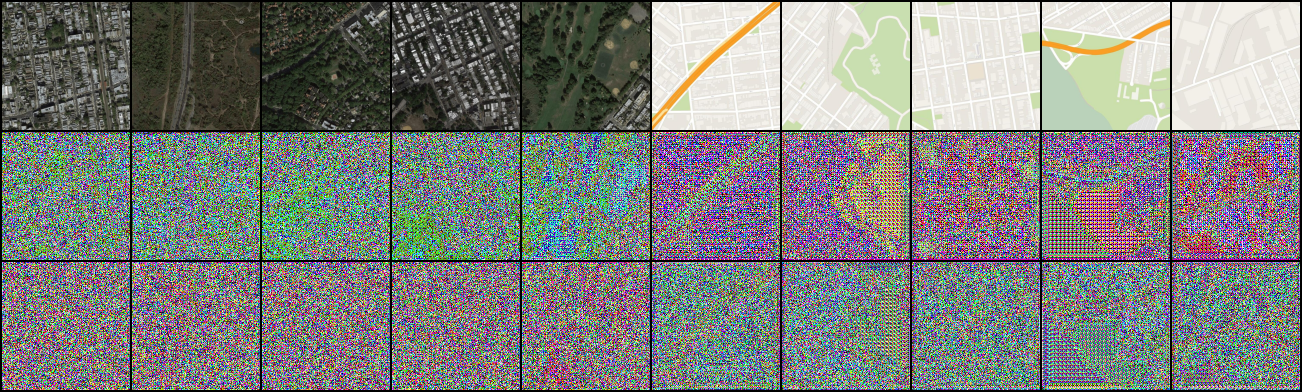

In [19]:
G, F, Dx, Dy, opt_gen, opt_disc = model_init()
write_image(G, F)

Epoch 1/3: 100%|██████████| 1096/1096 [00:32<00:00, 34.18it/s]

loss_Dx: 0.001505 | loss_Dy: 0.0004 | loss_gen: 9.4927


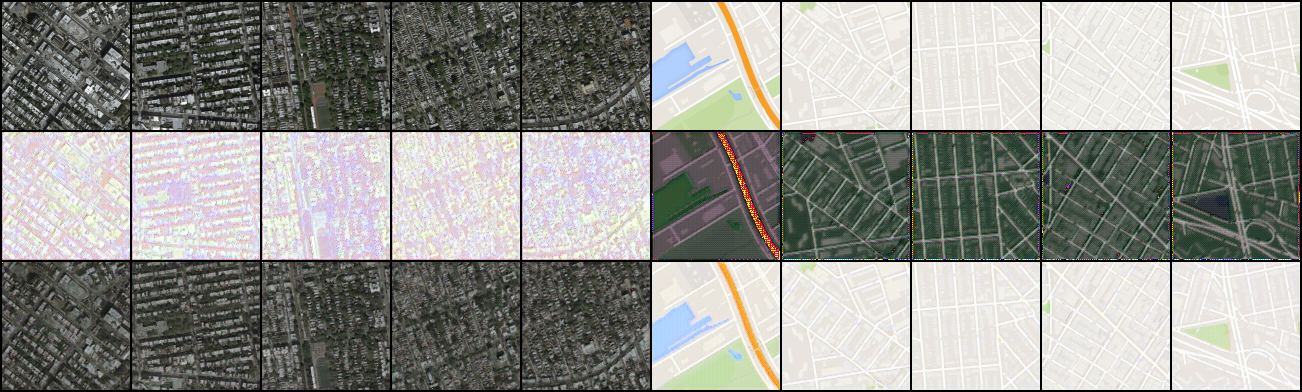

Epoch 2/3: 100%|██████████| 1096/1096 [00:32<00:00, 34.14it/s]

loss_Dx: 0.003197 | loss_Dy: 0.0017 | loss_gen: 8.5496


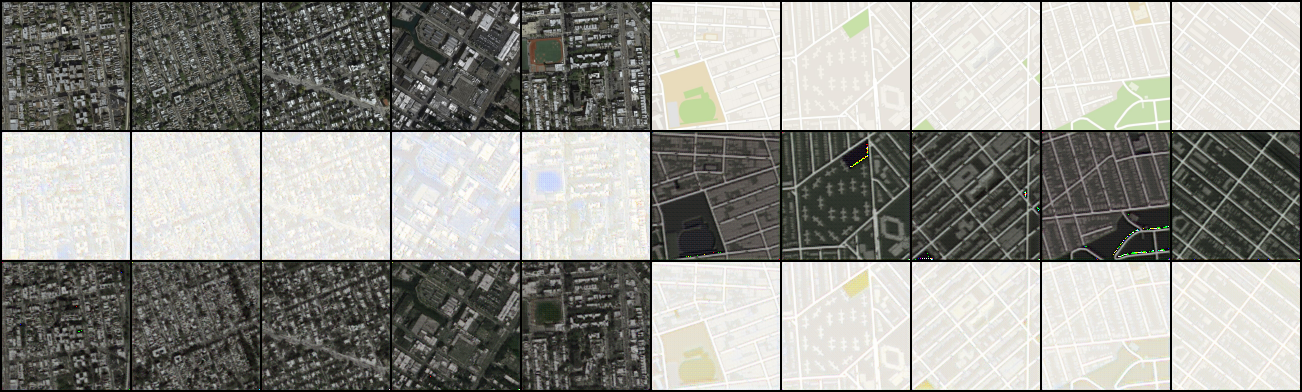

Epoch 3/3: 100%|██████████| 1096/1096 [00:32<00:00, 34.02it/s]


loss_Dx: 0.002616 | loss_Dy: 0.0009 | loss_gen: 8.9634


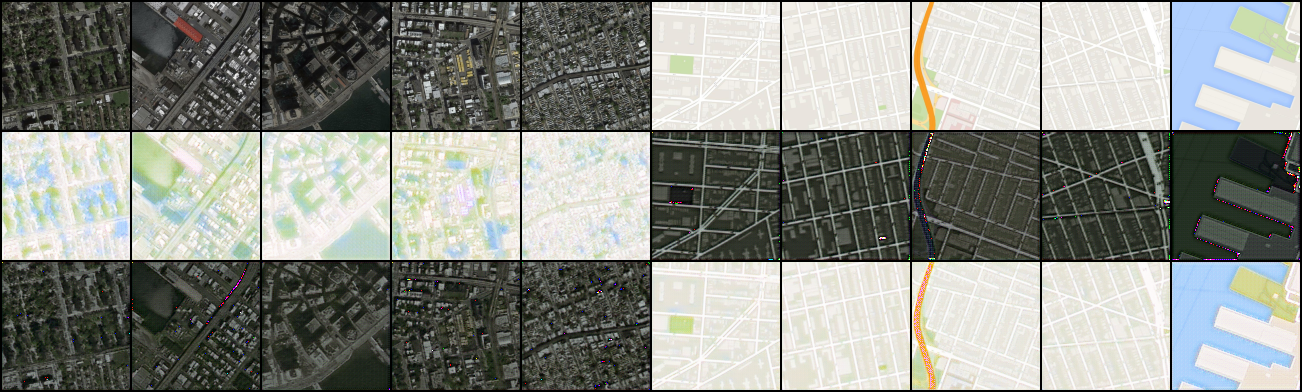

In [21]:
options = {
    "n_epochs": 3,
    "lambda_idt": 0.,
    "lambda_cycle": 5.,
    "lambda_adv": 5.,
}


train(G, F, Dx, Dy, opt_gen, opt_disc, dataloader, options)